# Downloading, Preparing, and Analyzing Paris Road Traffic Data for an Analysis Dashboard 🚗

##### Esri  France | Author: Pauline Louis

This notebook downloads, prepares, visualizes, and runs geoprocessing analysis tools related to Paris road traffic data.

![RoadTraffic](https://raw.githubusercontent.com/JapaLenos/Python-in-ArcGIS/main/Analysis/EuroDev2023-NotebooksInArcGISPro/assets/roadtraffic_illustration.jpg)

# Introduction

This notebook is composed of three sections:
1. Data retrieving and data engineering 🔎
2. Data visualization 📊
3. Analysis 🧪

# 1. Data Retrieving and Data Engineering 🔎

This section of the notebook downloads and prepares data for use with ArcGIS Pro's spatial data science tools. 

## Step 1: Download data from <a href="https://opendata.paris.fr/" target="_blank">Paris|Data</a> 📥

The CSV files (known cases, deaths, population for US counties) are downloaded from the <a href="https://opendata.paris.fr/" target="_blank">Paris|Data</a> website. It’s a provider of policy, economic, demographic, environmental and transport data. 
On this Open Data portal, we can find <a href="https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents/table/?disjunctive.libelle&disjunctive.etat_trafic&disjunctive.libelle_nd_amont&disjunctive.libelle_nd_aval&refine.t_1h=2023&sort=t_1h" target="_blank">historical records of Paris roads traffic.

In [1]:
import os                           # Used for interaction with the operating system
from datetime import date
import pandas as pd                 # Used for data management
import numpy as np                  # Used for array data structures
import matplotlib.pyplot as plt     # Used for plotting
import requests                     # Used to make HTML requests
import arcgis                       # Used to interact with Esri Living Atlas
import arcpy                        # Used to run data visualization and run analyses

# show plots after Notebook cells
%matplotlib inline        

In [2]:
# Set overwrite permissions and workspace
arcpy.env.overwriteOutput = True
workGDB = arcpy.env.workspace
workFolder = os.path.join(os.path.dirname(workGDB), "Downloaded_Data")
if not os.path.isdir(workFolder):
    os.mkdir(workFolder)
print(f"File geodatabase workspace: {workGDB}")
print(f"Folder for downloaded data: {workFolder}")

File geodatabase workspace: D:\arcpy\EuroDev23\Notebooks_in_Pro\Notebooks_in_Pro.gdb
Folder for downloaded data: D:\arcpy\EuroDev23\Notebooks_in_Pro\Downloaded_Data


### Download the data

[Note] Due to the large amount of data to download, the cell below has a quite long execution time

In [7]:
### Helper function to automatically download data from Paris|Data webpage
def download_ParisData_csvs(target_folder):
    
    # Set base url and data type csv names
    data_url_dict = {"comptages-routiers-permanents.csv":"https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptages-routiers-permanents/exports/csv?lang=fr&refine=t_1h%3A%222023%22&qv1=(t_1h%3A%5B2023-09-25T22%3A00%3A00Z%20TO%202023-10-26T21%3A59%3A59Z%5D)&timezone=Europe%2FParis&use_labels=true&delimiter=%3B"}
    
    # Iterate one each needed data type
    for data_name in data_url_dict:
        # Build the url
        url = f"{data_url_dict[data_name]}"
        print(f"Downloading {data_name} data from {url}...")
        
        req = requests.get(url, allow_redirects=True)
        url_content = req.content
        csv_file = open(f'{target_folder}//{data_name}', 'wb')
        csv_file.write(url_content)
        csv_file.close()
        print(f"{data_name} downloaded")
        
# Download data from USAFacts using the helper function
download_ParisData_csvs(workFolder)

comptages-routiers-permanents.csv downloaded


If the PC you are using to run this process does not have access, manually download the CSV files to the specified workFolder

### Read in CSV files using Pandas

In [4]:
# Read in CSV files using Pandas
print(os.path.join(workFolder, "comptages-routiers-permanents.csv"))
traffic = pd.read_csv(os.path.join(workFolder, "comptages-routiers-permanents.csv"),sep = ";", low_memory = False) 
traffic

D:\arcpy\EuroDev23\Notebooks_in_Pro\Downloaded_Data\comptages-routiers-permanents.csv


Identifiant arc  ...                                          geo_shape
0                    5356  ...  {"coordinates": [[2.4124537929110366, 48.87236...
1                    4807  ...  {"coordinates": [[2.350490321712138, 48.838500...
2                    1416  ...  {"coordinates": [[2.4026751258000254, 48.86970...
3                    4251  ...  {"coordinates": [[2.293402308492599, 48.885369...
4                    4898  ...  {"coordinates": [[2.3892869728649964, 48.88774...
...                   ...  ...                                                ...
25613662             6033  ...  {"coordinates": [[2.31629173359207, 48.8751673...
25613663             6033  ...  {"coordinates": [[2.31629173359207, 48.8751673...
25613664             6015  ...  {"coordinates": [[2.314316332620986, 48.875175...
25613665             6015  ...  {"coordinates": [[2.314316332620986, 48.875175...
25613666             6015  ...  {"coordinates": [[2.314316332620986, 48.875175...

[25613667 rows x 15 columns]

### Let's explore the data a bit further...

In [102]:
# Number of roads
nb_roads = traffic['Libelle'].nunique()
print(f"We have traffic data for {nb_roads} different roads ")

# Check out the top 5 occupation rates
print("The road(s) with the 5 top occupation rates are:")
traffic[["Libelle", "Taux d'occupation", "Date et heure de comptage"]].sort_values(by = "Taux d'occupation", ascending=False).head()

We have traffic data for 889 different roads 
The road(s) with the 5 top occupation rates are:


Libelle  Taux d'occupation  Date et heure de comptage
22467937  Av_du_Mal_Gallieni              100.0  2023-03-27T07:00:00+02:00
22466849  Av_du_Mal_Gallieni              100.0  2023-03-27T08:00:00+02:00
14560678  Av_du_Mal_Gallieni              100.0  2023-03-19T22:00:00+01:00
1683911   Av_du_Mal_Gallieni              100.0  2023-04-07T09:00:00+02:00
14560654  Av_du_Mal_Gallieni              100.0  2023-03-19T23:00:00+01:00

###### Be careful, one bad day does not necessarly indicate a a global trend !

In [103]:
mean_occupation_rate =traffic.groupby(['Libelle'])["Taux d'occupation"].mean()
mean_occupation_rate_df = mean_occupation_rate.to_frame()
mean_occupation_rate_df = mean_occupation_rate.reset_index()
mean_occupation_rate_df.sort_values(by = "Taux d'occupation", ascending=False).head()

Libelle  Taux d'occupation
376  Edouard_Vaillant          99.846670
323  Bercy_bretelle_8          46.224688
643      Pt_au_Change          45.675128
380    Fbg_St_Antoine          33.171583
48   AI_A3_bretelle_7          32.160440

In [104]:
quais = mean_occupation_rate_df.loc[mean_occupation_rate_df["Libelle"] == "Av_du_Mal_Gallieni"]
quais

Libelle  Taux d'occupation
200  Av_du_Mal_Gallieni           6.959234

## Step 2: Data cleaning and conversion 🧹

### Rename columns headers

In [5]:
traffic = traffic.rename(columns={'Identifiant arc': 'arc_id', 'Libelle': 'label','Date et heure de comptage':'date_time','Etat trafic':'traffic_conditions',"Taux d'occupation" : 'occupation_rate'})
traffic

arc_id  ...                                          geo_shape
0           5356  ...  {"coordinates": [[2.4124537929110366, 48.87236...
1           4807  ...  {"coordinates": [[2.350490321712138, 48.838500...
2           1416  ...  {"coordinates": [[2.4026751258000254, 48.86970...
3           4251  ...  {"coordinates": [[2.293402308492599, 48.885369...
4           4898  ...  {"coordinates": [[2.3892869728649964, 48.88774...
...          ...  ...                                                ...
25613662    6033  ...  {"coordinates": [[2.31629173359207, 48.8751673...
25613663    6033  ...  {"coordinates": [[2.31629173359207, 48.8751673...
25613664    6015  ...  {"coordinates": [[2.314316332620986, 48.875175...
25613665    6015  ...  {"coordinates": [[2.314316332620986, 48.875175...
25613666    6015  ...  {"coordinates": [[2.314316332620986, 48.875175...

[25613667 rows x 15 columns]

### Remove useless columns

In [6]:
traffic = traffic.drop(['Débit horaire', 'Identifiant noeud amont','Libelle noeud amont','Identifiant noeud aval','Libelle noeud aval','Etat arc','Date debut dispo data','Date fin dispo data','geo_point_2d','geo_shape'], axis=1)
traffic

arc_id            label  ... occupation_rate  traffic_conditions
0           5356  PI_Menilmontant  ...             NaN             Inconnu
1           4807  Av_des_Gobelins  ...        29.02111          Pré-saturé
2           1416      Av_Gambetta  ...             NaN             Inconnu
3           4251      Bd_Berthier  ...             NaN             Inconnu
4           4898   Av_Jean_Jaures  ...        13.77334              Fluide
...          ...              ...  ...             ...                 ...
25613662    6033         Argencon  ...         0.52278              Fluide
25613663    6033         Argencon  ...         0.99111              Fluide
25613664    6015     Bd_Haussmann  ...             NaN             Inconnu
25613665    6015     Bd_Haussmann  ...             NaN             Inconnu
25613666    6015     Bd_Haussmann  ...             NaN             Inconnu

[25613667 rows x 5 columns]

### Check for NaN values

In [7]:
traffic = traffic.dropna()
traffic

arc_id            label  ... occupation_rate  traffic_conditions
1           4807  Av_des_Gobelins  ...        29.02111          Pré-saturé
4           4898   Av_Jean_Jaures  ...        13.77334              Fluide
5            559          Turbigo  ...        10.41723              Fluide
6            267         Tronchet  ...         1.34167              Fluide
7            506  Bd_de_l'Hopital  ...         1.46778              Fluide
...          ...              ...  ...             ...                 ...
25613659    6020   Bd_Malesherbes  ...         0.56334              Fluide
25613660    6033         Argencon  ...         0.28167              Fluide
25613661    6033         Argencon  ...         0.38611              Fluide
25613662    6033         Argencon  ...         0.52278              Fluide
25613663    6033         Argencon  ...         0.99111              Fluide

[12480674 rows x 5 columns]

In [8]:
#We will also drop data a few road records as data analysis reveals problems with that data
droplist = ["Pt_au_Change","Av_Pte_d'Ivry","Av_Claude_Regaud","	Av_Pte_d_Ivry","Belgrand","A3_bretelle_1","AI_A3_bretelle_2"]
for elt in droplist :
    traffic.drop(traffic[traffic['label'] == elt].index, inplace = True)
traffic

arc_id            label  ... occupation_rate  traffic_conditions
1           4807  Av_des_Gobelins  ...        29.02111          Pré-saturé
4           4898   Av_Jean_Jaures  ...        13.77334              Fluide
5            559          Turbigo  ...        10.41723              Fluide
6            267         Tronchet  ...         1.34167              Fluide
7            506  Bd_de_l'Hopital  ...         1.46778              Fluide
...          ...              ...  ...             ...                 ...
25613659    6020   Bd_Malesherbes  ...         0.56334              Fluide
25613660    6033         Argencon  ...         0.28167              Fluide
25613661    6033         Argencon  ...         0.38611              Fluide
25613662    6033         Argencon  ...         0.52278              Fluide
25613663    6033         Argencon  ...         0.99111              Fluide

[12408634 rows x 5 columns]

In [10]:
# Re-check Number of roads
nb_roads = traffic['label'].nunique()
print(f"We have traffic data for {nb_roads} different roads ")

We have traffic data for 573 different roads 


### Translate traffic_conditions column

In [11]:
translate_dc = {"Fluide":"Fluid" , "Pré-saturé":"Pre-saturated" , "Saturé":"Saturated" , "Bloqué" : "Blocked"}
for fr, en in translate_dc.items() :
    traffic = traffic.replace(fr,en)
traffic

arc_id            label  ... occupation_rate  traffic_conditions
1           4807  Av_des_Gobelins  ...        29.02111       Pre-saturated
4           4898   Av_Jean_Jaures  ...        13.77334               Fluid
5            559          Turbigo  ...        10.41723               Fluid
6            267         Tronchet  ...         1.34167               Fluid
7            506  Bd_de_l'Hopital  ...         1.46778               Fluid
...          ...              ...  ...             ...                 ...
25613659    6020   Bd_Malesherbes  ...         0.56334               Fluid
25613660    6033         Argencon  ...         0.28167               Fluid
25613661    6033         Argencon  ...         0.38611               Fluid
25613662    6033         Argencon  ...         0.52278               Fluid
25613663    6033         Argencon  ...         0.99111               Fluid

[12408634 rows x 5 columns]

### Convert datetime field

In [12]:
traffic[['date','hour']] = traffic.date_time.str.split("T",expand = True)
traffic = traffic.drop(['date_time'], axis=1)
traffic

arc_id            label  ...        date            hour
1           4807  Av_des_Gobelins  ...  2022-12-06  18:00:00+01:00
4           4898   Av_Jean_Jaures  ...  2023-03-09  19:00:00+01:00
5            559          Turbigo  ...  2023-04-03  17:00:00+02:00
6            267         Tronchet  ...  2023-05-05  11:00:00+02:00
7            506  Bd_de_l'Hopital  ...  2023-06-07  13:00:00+02:00
...          ...              ...  ...         ...             ...
25613659    6020   Bd_Malesherbes  ...  2023-08-01  02:00:00+02:00
25613660    6033         Argencon  ...  2023-08-01  04:00:00+02:00
25613661    6033         Argencon  ...  2023-08-01  03:00:00+02:00
25613662    6033         Argencon  ...  2023-08-01  02:00:00+02:00
25613663    6033         Argencon  ...  2023-08-01  01:00:00+02:00

[12408634 rows x 6 columns]

In [13]:
# Convert datetime field
# Tips: using format = '%m/%d/%y' will be much faster than infer_datetime_format=True or saying nothing about format
traffic['DateTime'] =  pd.to_datetime(traffic['date'], format = '%Y/%m/%d')

#adds day name in a new column
traffic['day'] = traffic['DateTime'].dt.day_name() 

#display the 5 last rows
traffic.tail() 

arc_id           label  ...   DateTime      day
25613659    6020  Bd_Malesherbes  ... 2023-08-01  Tuesday
25613660    6033        Argencon  ... 2023-08-01  Tuesday
25613661    6033        Argencon  ... 2023-08-01  Tuesday
25613662    6033        Argencon  ... 2023-08-01  Tuesday
25613663    6033        Argencon  ... 2023-08-01  Tuesday

[5 rows x 8 columns]

### Export pandas dataframe to CSV

In [14]:
# Export pandas dataframe to CSV
MA_csv = os.path.join(workFolder, "Paris_road_traffic.csv")
traffic.to_csv(MA_csv)
MA_csv

'D:\\arcpy\\EuroDev23\\Notebooks_in_Pro\\Downloaded_Data\\Paris_road_traffic.csv'

### Quickly observe the data

In [16]:
# Check out the data for Avenue des Champs Elysées
champs = traffic.loc[traffic["label"] == "Av_Champs_Elysees"]
champs

arc_id              label  ...   DateTime        day
2415         223  Av_Champs_Elysees  ... 2023-07-18    Tuesday
2439         223  Av_Champs_Elysees  ... 2023-07-18    Tuesday
2463         223  Av_Champs_Elysees  ... 2023-07-18    Tuesday
6850         223  Av_Champs_Elysees  ... 2023-03-08  Wednesday
6873         223  Av_Champs_Elysees  ... 2023-03-08  Wednesday
...          ...                ...  ...        ...        ...
25608430    6815  Av_Champs_Elysees  ... 2023-02-01  Wednesday
25611636     223  Av_Champs_Elysees  ... 2023-08-01    Tuesday
25611638     223  Av_Champs_Elysees  ... 2023-08-01    Tuesday
25613102     223  Av_Champs_Elysees  ... 2023-08-01    Tuesday
25613103     223  Av_Champs_Elysees  ... 2023-08-01    Tuesday

[75851 rows x 8 columns]

#### Let's create some quick bar plots of the data in Champs Elysées

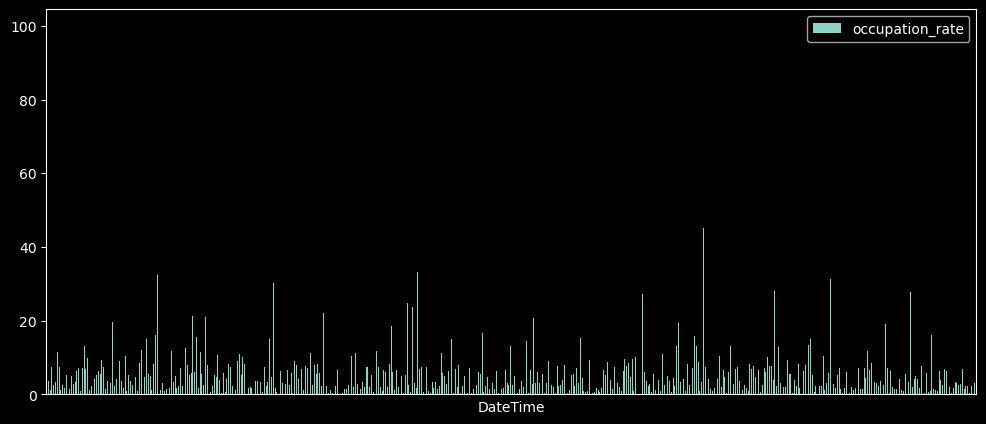

In [17]:
# Create a quick plot for the Champs Elysées data
ax = champs.plot.bar(x='DateTime', y='occupation_rate', rot= 0, figsize = (12,5))

# Remove xticks
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

## Step 3: Group by day, hour and label & and mean on occupation rate 📅

### A few more data engineering to obtain interesting data

We will group the data by hour, day, and label, and then calculate the mean occupation rate. This will provide us with the average occupation rate for each road, broken down by hour on weekdays.

In [43]:
group_traffic=traffic.groupby(['label','day','hour'])['occupation_rate'].mean()
group_traffic_df = group_traffic.to_frame()
group_traffic_df = group_traffic.reset_index()
group_traffic_df

label        day            hour  occupation_rate
0             4_Septembre     Friday  00:00:00+01:00         6.321901
1             4_Septembre     Friday  00:00:00+02:00         4.105861
2             4_Septembre     Friday  01:00:00+01:00         4.472200
3             4_Septembre     Friday  01:00:00+02:00         3.618220
4             4_Septembre     Friday  02:00:00+01:00         3.383214
...                   ...        ...             ...              ...
186461  Winston_Churchill  Wednesday  19:00:00+02:00         3.316766
186462  Winston_Churchill  Wednesday  20:00:00+02:00         2.993948
186463  Winston_Churchill  Wednesday  21:00:00+02:00         2.386230
186464  Winston_Churchill  Wednesday  22:00:00+02:00         2.369786
186465  Winston_Churchill  Wednesday  23:00:00+02:00         2.153642

[186466 rows x 4 columns]

We will now sort it by day and hour :

In [46]:
group_traffic_df['day'] = pd.Categorical(group_traffic_df['day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
group_traffic_df['hour'] = pd.Categorical(group_traffic_df['hour'], categories=[f'{i:02d}:00:00+02:00' for i in range(24)], ordered=True)
group_traffic_df = group_traffic_df.sort_values(by=['day', 'hour'])
group_traffic_df['day'] = group_traffic_df['day'].astype(str)
group_traffic_df['hour'] = group_traffic_df['hour'].astype(str)
group_traffic_df['day_hour'] = group_traffic_df['day'] + ' ' + group_traffic_df['hour']
group_traffic_df

label     day  ... occupation_rate               day_hour
49            4_Septembre  Monday  ...        2.739474  Monday 00:00:00+02:00
385         A3_bretelle_1  Monday  ...        0.000000  Monday 00:00:00+02:00
721      A6A_W_bretelle_9  Monday  ...       12.581667  Monday 00:00:00+02:00
1057    AE_A13_bretelle_5  Monday  ...        2.925000  Monday 00:00:00+02:00
1385     AE_A3_bretelle_1  Monday  ...        4.296667  Monday 00:00:00+02:00
...                   ...     ...  ...             ...                    ...
186384  Winston_Churchill  Sunday  ...        1.909440             Sunday nan
186386  Winston_Churchill  Sunday  ...        2.033890             Sunday nan
186388  Winston_Churchill  Sunday  ...        1.206670             Sunday nan
186390  Winston_Churchill  Sunday  ...        1.307220             Sunday nan
186392  Winston_Churchill  Sunday  ...        1.100560             Sunday nan

[186466 rows x 5 columns]

### Once again, let's observe the results on the Champs Elysées by creating a new bar plot of the road traffic data by day and hour

In [47]:
# Check out the data for Avenue des Champs Elysées
champs = group_traffic_df.loc[group_traffic_df["label"] == "Av_Champs_Elysees"]
champs = champs.drop(champs[champs['hour'] == 'nan'].index)
champs

label     day  ... occupation_rate               day_hour
17590  Av_Champs_Elysees  Monday  ...        4.417073  Monday 00:00:00+02:00
17592  Av_Champs_Elysees  Monday  ...        3.802701  Monday 01:00:00+02:00
17594  Av_Champs_Elysees  Monday  ...        2.786674  Monday 02:00:00+02:00
17596  Av_Champs_Elysees  Monday  ...        1.851038  Monday 03:00:00+02:00
17598  Av_Champs_Elysees  Monday  ...        1.217528  Monday 04:00:00+02:00
...                  ...     ...  ...             ...                    ...
17724  Av_Champs_Elysees  Sunday  ...        7.057831  Sunday 19:00:00+02:00
17726  Av_Champs_Elysees  Sunday  ...        6.935819  Sunday 20:00:00+02:00
17728  Av_Champs_Elysees  Sunday  ...        6.450425  Sunday 21:00:00+02:00
17730  Av_Champs_Elysees  Sunday  ...        5.452654  Sunday 22:00:00+02:00
17732  Av_Champs_Elysees  Sunday  ...        4.840950  Sunday 23:00:00+02:00

[168 rows x 5 columns]

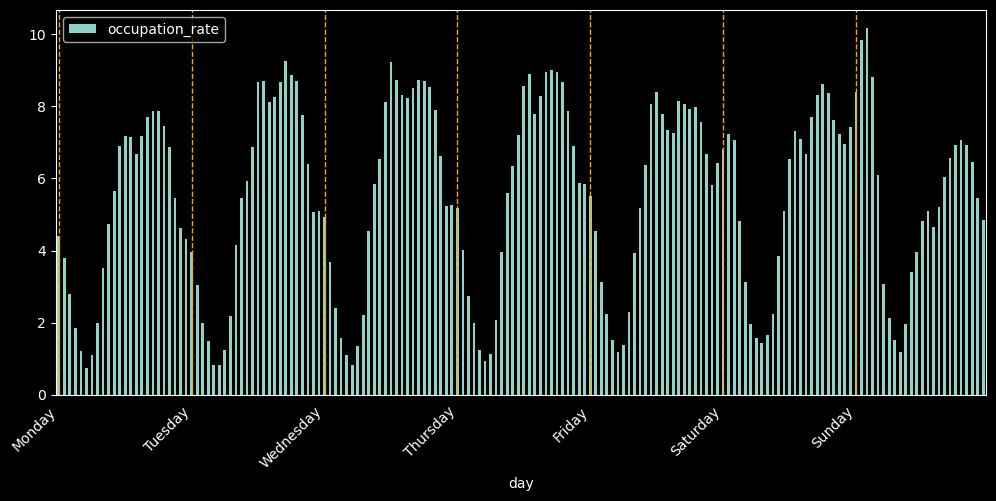

In [48]:
# Create a quick plot for Champs Elysées data
ax = champs.plot.bar(x='day', y='occupation_rate', rot= 0, figsize = (12,5))

# Remove xticks
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
ax.set_xticks(ax.get_xticks()[::24])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for label in ax.get_xticklabels():
    xpos = label.get_position()[0]
    ax.axvline(x=xpos, color='orange', linewidth=1, linestyle='--')
    
plt.show()
# References: 
# [Remove xticks] https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
# [Configure plot size] https://stackoverflow.com/questions/51174691/how-to-increase-image-size-of-pandas-dataframe-plot-in-jupyter-notebook/51174822

## Step 4: Create Space Time Cube using Defined Locations with ArcPy 🎲

When using this data in a space time cube, the cases are aggregated spatially (counties) and temporally (daily, weekly, monthly).

This section will create space time cubes for each temporal aggregation. Additionally, we can also create cubes containing spatial and temporal subsets of the data: 
    - cube for one state, ex. California
    - cube for a certain time period, ex. 7/1/2020 - 12/31/2020.

### We need to get a county layer for geometry 

I can retrieve data hosted on [ArcGIS Online](https://arcgis.com), where we can find a service containing [Paris road metering reference frame](https://esrifrance.maps.arcgis.com/home/item.html?id=dde41f6b77ca4488ad38eae1448cfe92&sublayer=1#overview). 

In [15]:
# Authenticate with a GIS using the ArcGIS API for Python
gis = arcgis.gis.GIS()

In [16]:
# Search for Paris road metering reference frame
search = gis.content.search("Ref comptage routier Paris", item_type="feature_service", outside_org=True, sort_field="numViews")
# Use the correct index to reference the search result
Paris_roads = search[0]
Paris_roads

<Item title:"Ref comptage routier Paris" type:Feature Layer Collection owner:plouis_esrifrance>

In [17]:
# Load the dataset into a spatially-enabled dataframe
Paris_roads_sedf = pd.DataFrame.spatial.from_layer(Paris_roads.layers[0])
Paris_roads_sedf = Paris_roads_sedf[['OBJECTID', 'label', 'SHAPE', 'Shape__Area', 'Shape__Length']]
Paris_roads_sedf

OBJECTID                     label  ... Shape__Area  Shape__Length
0           1               4_Septembre  ...    0.000001       0.015282
1           2                8_mai_1945  ...    0.000001       0.017678
2           3       A._Rivoire-D._Weill  ...    0.000001       0.009754
3           4             A1_bretelle_8  ...         0.0       0.001612
4           5                      A1_W  ...         0.0       0.003628
..        ...                       ...  ...         ...            ...
981       982  VGP_Souterrain_Tuileries  ...    0.000001       0.026567
982       983           Victor_Marchand  ...         0.0       0.002852
983       984                Voie_Mazas  ...    0.000001       0.009794
984       985                   Vouille  ...    0.000001       0.019127
985       986         Winston_Churchill  ...    0.000001       0.011765

[986 rows x 5 columns]

In [18]:
# Save the spatially-enabled dataframe into a Feature Class
counties_fc = Paris_roads_sedf.spatial.to_featureclass(os.path.join(workGDB, "Paris_road_ref"))

In [19]:
# Project the data
arcpy.management.Project("Paris_road_ref",
    "Paris_road_ref_Project",
    'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",44.0],PARAMETER["Standard_Parallel_2",49.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]',
    "RGF_1993_To_WGS_1984_1",
    'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
    "NO_PRESERVE_SHAPE",
    None,
    "NO_VERTICAL"
)

<Result 'D:\\arcpy\\EuroDev23\\Notebooks_in_Pro\\Notebooks_in_Pro.gdb\\Paris_road_ref_Project'>

### Convert CSV to a Space Time Cube

We are going to create a Space Time Cube using the [Create Space Time Cube From Defined Locations](https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/createcubefromdefinedlocations.htm) tool with ArcPy
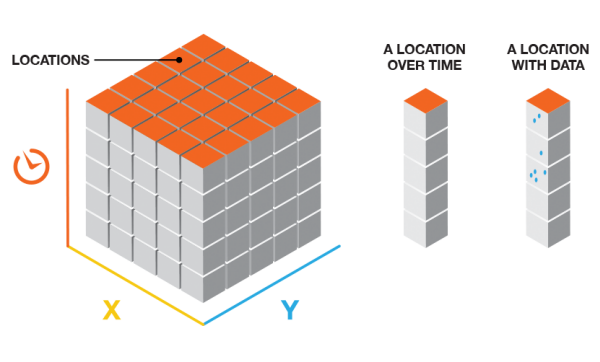

#### Helper function to convert CSV to a Space Time Cube

In [20]:
def createCubeFromCSV_withMA(csvWithPath, workFolder, daily = False, weekly = True, monthly = True):
    ### Function to create cube with 7-day moving average & per 100K residents ###
    ### Also can aggregate daily data to weekly and monthly (30-day actually) ###
    csv = os.path.basename(csvWithPath)
    tb = csv.split(".")[0]
    # output cube = use the same name with CSV, will be saved at workFolder
    outputCube = os.path.join(workFolder, tb + ".nc")
    
    # template feature = Paris roads polygons
    gdb = workGDB
    templateFC = os.path.join(workGDB, "Paris_road_ref_Project")
    # Convert csv to a table in data.gdb
    arcpy.conversion.TableToTable(csvWithPath, gdb, tb)
    tbName = os.path.join(gdb, tb)
    
    if daily:
        # Create Space Time Cube From Defined Locations - daily
        outputCube_daily = os.path.join(workFolder, f"{tb}_1day.nc")
        arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(templateFC, outputCube_daily, "label", "APPLY_TEMPORAL_AGGREGATION", "DateTime", "1 Days", "END_TIME", None, None, "occupation_rate MEAN ZEROS", tbName, "label")
        print("daily cube created")
     
    if weekly:
        # Create Space Time Cube From Defined Locations - weekly aggregation
        outputCube_weekly = os.path.join(workFolder, f"{tb}_1week.nc")
        arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(templateFC, outputCube_weekly, "label", "APPLY_TEMPORAL_AGGREGATION", "DateTime", "1 Weeks", "END_TIME", None, None, "occupation_rate MEAN DROP_LOCATIONS", tbName, "label")
        print("weekly cube created")
    
    if monthly:
        # Create Space Time Cube From Defined Locations - 30-Day aggregation
        outputCube_monthly = os.path.join(workFolder, f"{tb}_30days.nc")
        arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(templateFC, outputCube_monthly, "label", "APPLY_TEMPORAL_AGGREGATION", "DateTime", "30 Days", "END_TIME", None, None, "occupation_rate MEAN DROP_LOCATIONS", tbName, "label")
        print("monthly cube created")
    return

#### Call the function to create the cube 

[Note] This step may take a few moments to run...

In [21]:
# Create cube with 7-day moving average & per 100K residents
createCubeFromCSV_withMA(MA_csv, workFolder, daily=False, weekly=True, monthly=True)

weekly cube created
monthly cube created


#### Visualize Space Time Cube in 3D

Best practice: use history to retrieve arcpy code

![BestPractice](https://raw.githubusercontent.com/JapaLenos/Python-in-ArcGIS/main/Analysis/EuroDev2023-NotebooksInArcGISPro/assets/Best-Practice.png)

#### Optional: Create cube for selected roads

In [28]:
# Create small cube for five counties in NYC
labels = ['Quai_Austerlitz', 'Bercy_bretelle_8', 'Av_Champs_Elysees']
selected_roads_csv = os.path.join(workFolder, f'Paris_selected_road_traffic.csv')
df_sr = traffic.loc[traffic['label'].isin(labels)]
df_sr.to_csv(selected_roads_csv)
createCubeFromCSV_withMA(selected_roads_csv, workFolder)

daily cube created


#### Optional: Create cube for selected time period

In [30]:
# Create cube for a certain time period
start_date = '2023-10-01'
end_date = '2023-10-10'
separator = ''
startDateString = separator.join(start_date.split('-')[1:])
endDateString = separator.join(end_date.split('-')[1:])
certainDates_csv = os.path.join(workFolder, f'road_traffic_from_{startDateString}_to_{endDateString}.csv')

df_only_certainDates = traffic.loc[(traffic['DateTime'] >= start_date) & (traffic['DateTime'] <= end_date)]
df_only_certainDates.to_csv(certainDates_csv)
createCubeFromCSV_withMA(certainDates_csv, workFolder)

daily cube created


# 2. Data Visualization 📊

Reference: 
<a href="https://www.arcgis.com/home/item.html?id=5e08c75b489c416ca607f8a6a7f5c344" target="_blank">ArcGIS Notebook - Using Arcpy Charts to Visualize COVID</a>

- <b>Pie Chart</b>: Global Traffic condition rates 🥧
- <b>Calendar Heat Chart</b>: Mean Occupation Rate by Day and Month 📆
- <b>Matrix Heat Chart</b>: Daily Mean Occupation Rate by Road 📅

In [23]:
# Read the table of Paris Road Traffic from Contents in your activated Map
table = arcpy.mp.ArcGISProject('current').activeMap.listTables()[0]
table.name

'Paris_road_traffic'

## Pie Chart 🥧

First, start with a simple <b>bar chart showing the total COVID cases for each county in Califronia</b>. 

To do so, we initialize an ArcPy Pie Chart object c and configuring the properties:  title, axis fields, category field, and display size (width, length). Also take note of the dataSource property, which is pointed to the table variable read in the previous cell(s), to specify the feature layer/stand-alone table you want to create chart based off. If it's not listed in TOC, you can point it to the full path of the feature class. 

After the ArcPy Chart object is created, we can: 1) export it to a local SVG file by the chart object's `exportToSVG` method, 2) add it to the feature layer/stand-alone table in TOC by the `addToLayer` method, 3) show under the cell in ArcGIS Notebook.


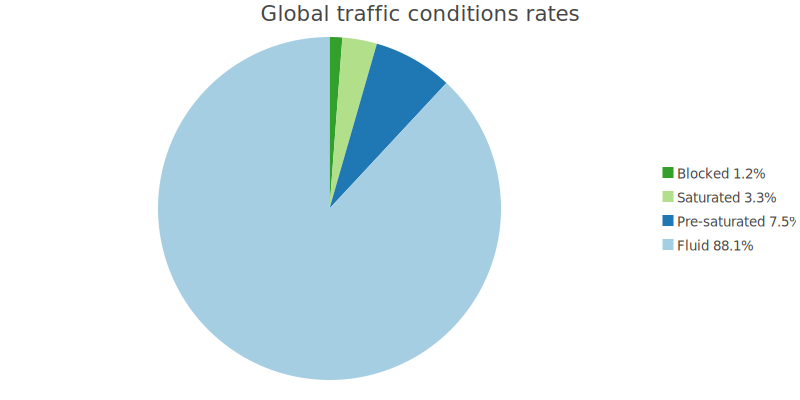

In [24]:
c = arcpy.charts.Pie('Traffic condition rates')
c.title = f"Global traffic conditions rates"
c.categoryField = 'traffic_conditions'
c.dataLabelsDisplay = 'PERCENTAGE'
c.groupingPercent = 0
c.displaySize = 800, 400
c.dataSource = table
# c.exportToSVG('global_traffic_conditions_rates.svg')
c.addToLayer(table) 
c

## Calendar Heat Chart 📆

We can also view aggregated COVID-19 cases over time from a slightly different perspective by creating a <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/calendar-heat-chart.htm" target="_blank">calendar heat chart</a>. <b>This chart aggregates means occupaton rates of all roads in Paris and displays them in a calendar grid.</b> The calendar heat chart is effective at showing a per day summary of temporal data, and the color for each cell is determined by a graduated natural breaks scheme.

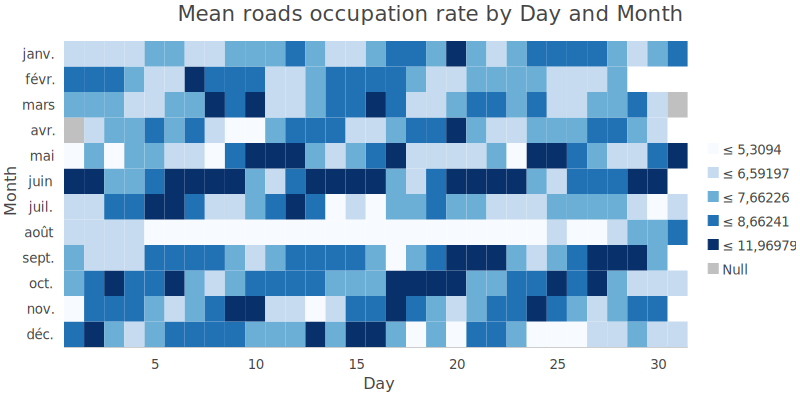

In [25]:
c = arcpy.Chart('traffic_conditions_calendar')
c.type = 'calendarHeatChart'
c.title = "Mean roads occupation rate by Day and Month"
c.xAxis.field = 'DateTime'
c.xAxis.title = "Day"
c.yAxis.field = 'occupation_rate'
c.yAxis.title = "Month"
c.calendarHeatChart.aggregation = 'mean'
c.displaySize = 800, 400
c.dataSource = table
# c.exportToSVG('covid19_calendar.svg')
c.addToLayer(table) 
c

## Matrix Heat Chart 📅

Having visualized the daily new COVID-19 cases aggregated for the entire state, we may also be interested in <b>comparing daily cases between roads within Paris</b>. 

Since ArcGIS Pro 2.7, we can display this data by creating a <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/matrix-heat-chart.htm#GUID-44D462F3-5E67-46DD-BD1C-862003D2EA5C" target="_blank">matrix heat chart</a> to display each road in a separate row. Matrix heat charts are used to visualize relationships between categorical or date fields with a grid of shaded cells. Here we will view each day on the X-axis by set the chart object's `xAxis.field` property, or Column category in the Chart Properties Pane. To view each county on the Y-axis, and use `occupation_rate` field to determine the intensity of the cell shading, we need to parse a list of the two Field names to the chart object's `yAxis.field` property. Also we can specify the symbology of the cell shading using 7-category Natural Breaks.

Note that we will run this on a recuced amount of data, as it cannot handle all of the 500+ roads in one chart.

### Data subset for the 15th arrondissement

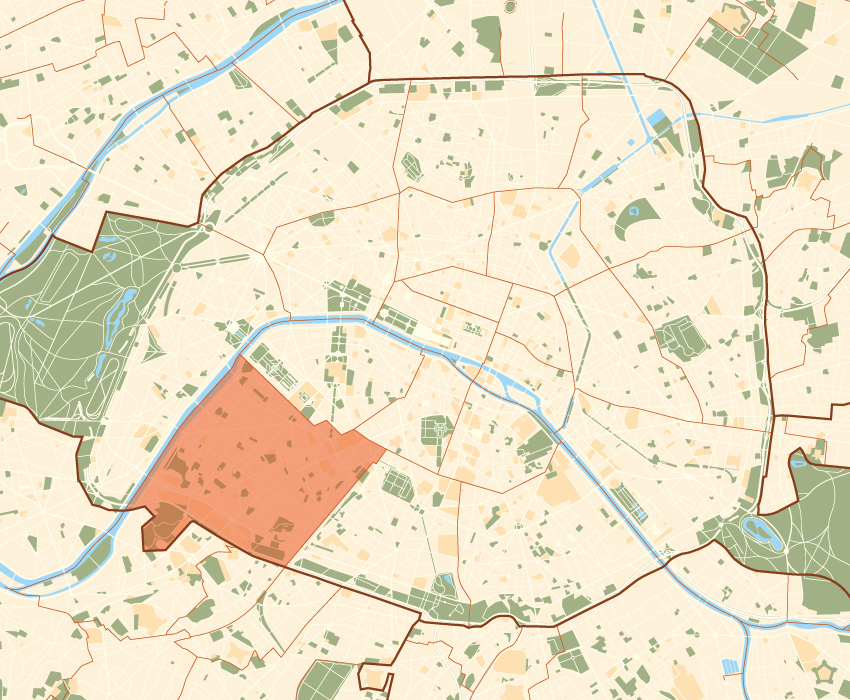

In [26]:
labels = ["Acces_BP_Quai_d'Issy","Acces_BP_Quai_d'Issy_bretelle_3","AE_Brancion_1","AE_Plaine","AE_Quai_d'Issy_bretelle_3","AE_Sevres","AI_Brancion",
          "AI_Quai_d'Issy_bretelle_4","AI_Sevres","Amiral_Cloue-Pt_Mirabeau","Av_du_Maine","Av_Emile_Zola","Av_Pte_Brancion","Av_Pte_de_la_Plaine",
          "Av_Pte_de_Sevres","Av_Pte_Sevres","Bd_Adolphe_Pinard","Bd_de_Grenelle","Bd_des_Invalides","Bd_Gal_Martial_Valin","Bd_Garibaldi","Bd_Grenelle",
          "Bd_Lefebvre","Bd_Montparnasse","Bd_Pasteur","Bd_Pegoud","Bd_Victor","Carlo_Sarabezolles","Claude_Garamond","Commerce","Convention","Emile_Zola",
          "Ernest_Renan","Felix_Faure","Fremicourt","Gal_Guillaumat","Javel","Lecourbe","Linois","PE_Brancion","PE_Heliport","PE_Louis_Vicat","PE_Parc_Expo_Est",
          "PE_Parc_Expo_Ouest","PE_Plaine","PE_Pont_aval","PE_Quai_Issy","PE_Sevres","PI_Brancion","PI_Heliport","PI_Louis_Vicat","PI_Parc_Expo_Est",
          "PI_Parc_Expo_Ouest","PI_Plaine","PI_Pont_Aval","PI_Quai_Issy","PI_Sevres","Pont_du_Garigliano","Pt_de_Bir_Hakeim","Pt_de_Grenelle",
          "Pt_Mirabeau-Amiral_Cloue","Pte_Brancion","Quai_Andre_Citroen","Quai_Branly","Quai_d'Issy","Quai_d'Issy-Leblanc","Quai_d'Issy_bretelle_1",
          "Quai_d'Issy_bretelle_4","Quai_de_Grenelle","Quai_Issy_bretelle_2","Quai_Issy_bretelle_4b","Rd_Point_Pte_Sevres","Rennes","Rond_Pt_Pte_Plaine",
          "Rue_Balard","SE_Brancion","SE_Quai_d'Issy_bretelle_2","SE_Sevres","Sevres","SI_Plaine","SI_Quai_Issy_bretelle_1","SI_Sevres","Sout_Citroen",
          "Souterrain_Citroen","Souterrain_Maine","Vaugirard","Vouille"]


selected_roads_csv = os.path.join(workFolder, f'Paris_15_road_traffic.csv')
df_sr = traffic.loc[traffic['label'].isin(labels)]
df_sr.to_csv(selected_roads_csv)
tb = "Paris_15_road_traffic"
gdb = workGDB
arcpy.conversion.TableToTable(selected_roads_csv, gdb, tb)

<Result 'D:\\arcpy\\EuroDev23\\Notebooks_in_Pro\\Notebooks_in_Pro.gdb\\Paris_15_road_traffic'>

### Chart

In [27]:
# Read the table of Paris Road Traffic from Contents in your activated Map
table_only15 = arcpy.mp.ArcGISProject('current').activeMap.listTables()[1]
table_only15.name

'Paris_15_road_traffic'

In [28]:
c = arcpy.Chart('daily_occupation_rate_by_road')
c.type = 'matrixHeatchart'
c.title = f"Daily Occupation Rates by road in the 15th arrd."
c.xAxis.field = 'DateTime'
c.xAxis.title = 'Day'
c.yAxis.field = ['label', 'occupation_rate']
c.yAxis.title = 'roads'
c.matrixHeatChart.aggregation = 'mean'
c.matrixHeatChart.classificationMethod = 'naturalBreaks'
c.matrixHeatChart.classCount = 7
c.matrixHeatChart.nullPolicy = 'zero'
c.legend.title = "Occupation rates"
c.displaySize = 1300, 1000
c.dataSource = table_only15
# c.exportToSVG('daily_occupation_rate_by_road.svg')
c.addToLayer(table_only15)
c

# 3. Analysis 🧪

There are various tools that can be used to Paris roads traffic across space and time. In this section, we'll apply two methods: 
- Time Series Clustering ⏱
- Change Point Detection 📈

By using a notebook and recording the arcpy calls in this script, we can make it easy to repeat and share the analysis. 

## <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/time-series-clustering.htm" target="_blank">Time Series Clustering</a> ⏱

In [38]:
def clustering(inCube, field, outputName, runProfile = True, runFourier = True, runValue= True, numClusters = 4, ignore = None, createPopups = True):
    """ Cluster with three Characteristics of Interests together 
    
    Keyword arguments:
    inCube -- Input Space Time Cube with full path (string)
    field -- Cube Variable (string)
    runProfile -- Boolean for using Profile (Correlation) as character of interest (boolean, default = True)
    runFourier -- Boolean for using Profile (Fourier) as character of interest (boolean, default = True)
    runValue -- Boolean for using Value as character of interest (boolean, default = False)
    numClusters -- Number of clusters (int, default = None, auto-detect the optimal # clsuter with min F-stats)
    ignore -- Time Series Characteristics to Ignore, "TIME_LAG"|"RANGE" (string, default = None)
    createPopups -- Boolean for Enable Time Series Pop-ups in output feature (boolean, default = True)
    """
    # Run Profile (Correlation)
    if runProfile:
        outputFc = os.path.join(workGDB, f"{outputName}_TSC_Profile")
        outputChart = os.path.join(workGDB, f"{outputName}_TSC_Profile_Charts")
        arcpy.stpm.TimeSeriesClustering(inCube, field, outputFc, "PROFILE", numClusters, outputChart, None, createPopups)
    # Run Profile (Fourier)
    if runFourier:
        outputFc = os.path.join(workGDB, f"{outputName}_TSC_Fourier")
        outputChart = os.path.join(workGDB, f"{outputName}_TSC_Fourier_Charts")
        arcpy.stpm.TimeSeriesClustering(inCube, field, outputFc, "PROFILE_FOURIER", numClusters, outputChart, ignore, createPopups)
    # Run Profile (Value)
    if runValue:
        outputFc = os.path.join(workGDB, f"{outputName}_TSC_Value")
        outputChart = os.path.join(workGDB, f"{outputName}_TSC_Value_Charts")
        arcpy.stpm.TimeSeriesClustering(inCube, field, outputFc, "VALUE", numClusters, outputChart, None, createPopups)
    return

#### Run the function

In [39]:
# Input parameters for time series clustering
cube = "Paris_road_traffic_1week.nc"
inCube = os.path.join(workFolder, cube)
field = "OCCUPATION_RATE_MEAN_NONE"
outputName = "TSC_Paris_Road__traffic_1week"

# Clustering
clustering(inCube, field, outputName)

#### Results

![TSCResults](https://raw.githubusercontent.com/JapaLenos/Python-in-ArcGIS/main/Analysis/EuroDev2023-NotebooksInArcGISPro/assets/TSC%20Maps%20%26%20Charts.png)

## <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/change-point-detection.htm" target="_blank">Change Point Detection</a>  📈

In [58]:
def changepoint(inCube, field, outputName, runMean=True, runCount=True, runStdDev=True, runSlope=False):
    """ Cluster with three Characteristics of Interests together 
    
    Keyword arguments:
    inCube -- Input Space Time Cube with full path (string)
    field -- Cube Variable (string)
    outputName -- Output name for the layer (string)
    runMean -- Boolean for using Mean change point detection (boolean, default = True)
    runCount -- Boolean for using Mean change point detection (boolean, default = True)
    runStdDev -- Boolean for using Mean change point detection (boolean, default = True)
    numSlope -- Boolean for using Mean change point detection (boolean, default = True)

    createPopups -- Boolean for Enable Time Series Pop-ups in output feature (boolean, default = True)
    """
    if runMean:
        outputFc = os.path.join(workGDB, f"{outputName}_CPD_Mean")
        arcpy.stpm.ChangePointDetection(inCube, field, outputFc, "MEAN", "AUTO_DETECT", 1, 0.5)
    if runCount:
        outputFc = os.path.join(workGDB, f"{outputName}_CPD_Count")
        arcpy.stpm.ChangePointDetection(inCube, field, outputFc, "COUNT", "AUTO_DETECT", 1, 0.5)        
    if runStdDev:
        outputFc = os.path.join(workGDB, f"{outputName}_CPD_StdDev")
        arcpy.stpm.ChangePointDetection(inCube, field, outputFc, "STANDARD_DEVIATION", "AUTO_DETECT", 1, 0.5)   
    if runSlope:
        outputFc = os.path.join(workGDB, f"{outputName}_CPD_Slope")
        arcpy.stpm.ChangePointDetection(inCube, field, outputFc, "SLOPE", "AUTO_DETECT", 1, 0.5)           
    return

#### This cell will take a few minutes to run...

In [59]:
# Input parameters for time series clustering
cube = "Paris_road_traffic_1day.nc"
inCube = os.path.join(workFolder, cube)
field = "OCCUPATION_RATE_MEAN_ZEROS"
outputName = "CPD_Paris_Road__traffic_1day"

# Change Point Detection
changepoint(inCube, field, outputName)